In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.filterwarnings("ignore")

In [4]:
# напишем общую функцию для распаковки данных

def open_data(data):
  display(data.head(5))
  print('-------------------------------')
  print('Общая информация')
  data.info()
  print('-------------------------------')
  print('Описание данных')
  display(data.describe())
  print('-------------------------------')
  print('Количество дубликатов')
  print(data.duplicated().sum())
  print('-------------------------------')
  print('Количество пропусков')
  print(data.isna().sum())

## Знакомство с данными

In [5]:
data = pd.read_csv('/content/drive/My Drive/Collab file/autos.csv')

In [6]:
open_data(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-------------------------------
Количество дубликатов
4
-------------------------------
Количество пропусков
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


### Предобработка данных

In [7]:
# приведем названия столбцов в порядок, для начала уберем заглавные буквы

data.columns = data.columns.str.lower()

На мой взгляд в данных присутствуют лишние признаки, которые не повлияют на конечный результат, чтобы облегчить работу алгоритма, удалим их. Данные признаки не несут существенной информации, которая могла бы помочь в определении цены. 

- ***datecrawled*** - на мой взгляд, на стоимость это никак не влияет, так как это просто цифра, которая показывает, когда анкету закачали в базу.
- **registrationmonth** - у нас есть в данных год регистрации автомобиля, не думаю, что есть сильная зависимость между стоимостью и месяцем регистрации.
- **datecreated** - не имеет значения, когда анкета была создана, ведь важно ее наполнение.
- **numberofpictures** - все значения в этом столбце нулевые (предварительно проверено).
- **postalcode** - нам не важно, какой почтовый индекс имеет владелец авто, так как важны параметры самого автомобиля.
- **lastseen** - точно так же, как и с почтовым индексом.

In [8]:
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [9]:
#теперь преобразуем ряд названий в соответствии с правилами змеиного регистра

data.rename(columns={'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 'fueltype': 'fuel_type', 'notrepaired': 'not_repaired'}, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   not_repaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


План по предобработке:

- **price** проверим данные в столбце.
- **vehicle_type** можно заменить пропуски на наиболее частые значения по моделям.
- **registration_year** оставим реальные значения, хоть тут и нет пропусков. Проанализируем данные.
- **gearbox** вместо пропусков укажем **manual**, наверняка это значение воспринимается по умолчанию. Также по данным в интернете удалось узнать, что в России преобладают машины с МКПП.
- **power** рассмотрим какие значения есть и оставим только приблеженные к реальности.
- **model** скорее всего придется удалить пропуски.
- **kilometer** рассмотрим какие значения есть и оставим только приблеженные к реальности, пропусков в данном столбце нет.
- **fuel_type** заменим пропуски на **petrol** - самое частое значение.
- **not_repaired** пропущенные значения поменяем на yes, так как скорее всего данное поле не заполнялось по причине того, что машина не чинилась.
- удалить дубликаты.

Text(0, 0.5, 'Количество объявлений')

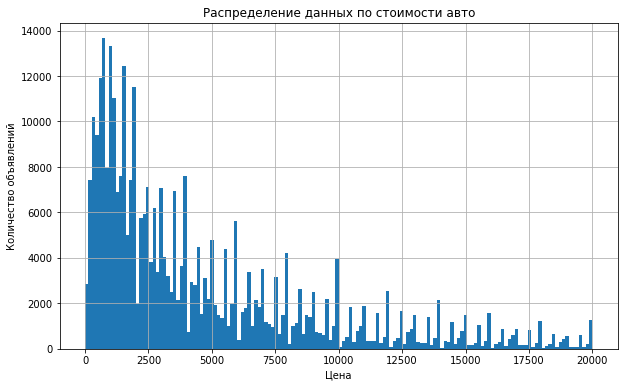

In [11]:
# посмотрим на распределение данных по ценам, в предварительном анализе мы увидели,
# что столбец содержит нулевые значения

data_new = data.query('price > 1')

data_new['price'].plot(kind='hist', bins=150, x='price', grid=True, figsize=(10, 6))
plt.title('Распределение данных по стоимости авто')
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')

In [12]:
data_new['price'].describe()

count    342408.000000
mean       4570.936006
std        4514.894622
min           2.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

**Комментарий:**
<br>После того, как мы избавились от нулевых значений, мы получили данные на 12 тыс. меньше. Также все еще остаются аномально низкие значения, например - 2. В целом мы наблюдаем достаточно большой пик в районе до 2 тыс. На мой взгляд, стоимость поддержанного автомобиля в текущих реалиях как минимум должна начинаться от 700 евро (это примерно 55 тыс.руб.). Поэтому я бы отсекла все, что ниже этой стоимости, так как здесь явно присутствуют ошибки/опечатки.

In [13]:
data_new = data_new.query('price >= 700')

Text(0, 0.5, 'Количество объявлений')

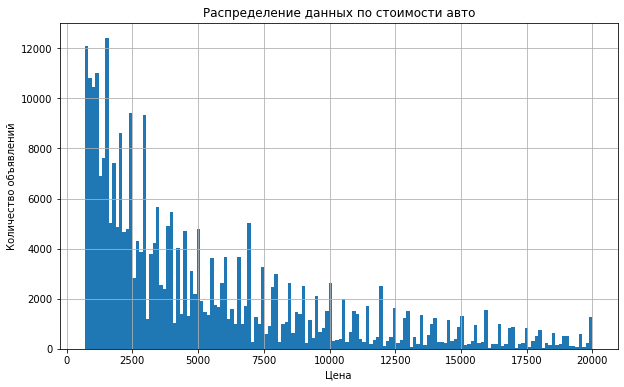

In [14]:
data_new['price'].plot(kind='hist', bins=150, x='price', grid=True, figsize=(10, 6))
plt.title('Распределение данных по стоимости авто')
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')

**Комментарий:**
<br>По-прежнему наблюдается большое количество дешевых объявлений.

In [15]:
data_new = data_new.loc[~data_new['model'].isna()]

In [16]:
data_new['model'].isna().sum()

0

In [17]:
data_new['vehicle_type'].value_counts()

sedan          78456
small          59209
wagon          56171
bus            26370
convertible    18470
coupe          13479
suv            10929
other           2252
Name: vehicle_type, dtype: int64

Заменим пропуски на на наиболее частое значение, используя данные по моделям.

In [18]:
data_new['vehicle_type'] = data_new['vehicle_type'].fillna(data_new.groupby('model')['vehicle_type'].transform(lambda x: x.value_counts().idxmax()))

In [19]:
data_new['vehicle_type'].isna().sum()

0

In [20]:
data_new['registration_year'].unique()

array([2004, 2001, 2008, 2014, 1998, 2005, 1995, 2011, 2007, 2009, 2002,
       2018, 2017, 1981, 2016, 1991, 1984, 2006, 2012, 2010, 2000, 1992,
       1993, 1997, 2013, 2003, 1999, 1996, 1990, 1989, 2015, 1985, 1982,
       1994, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965,
       1970, 1945, 1974, 1955, 1978, 1979, 1972, 1968, 1977, 1966, 1975,
       1910, 1963, 1967, 9999, 1960, 1500, 1964, 2066, 1949, 2019, 1937,
       1951, 1959, 1953, 1954, 1958, 1956, 1962, 9000, 2900, 5911, 1400,
       5000, 1961, 4000, 1952, 8500, 1932, 1950, 1000, 3700, 1942, 1933,
       1936, 1957, 1923, 2290, 1930, 1001, 7000, 1929, 1943, 1938, 1934,
       1935, 1928, 1941, 5555, 1800, 6000, 1931, 4500, 7800, 1947, 1927,
       7100, 1600])

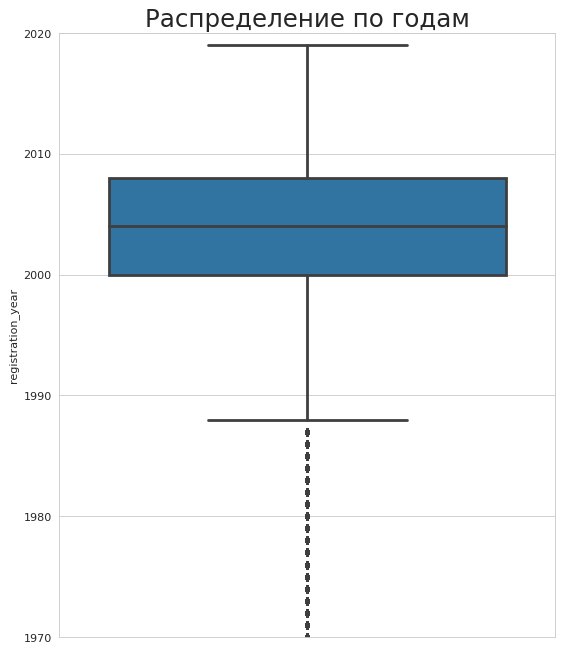

In [21]:
# посмотрим на распределение данных

name = 'Распределение по годам'

plt.figure(figsize=(8,10), dpi= 80)
sns.set_style('whitegrid')
sns.boxplot(y='registration_year', data=data_new, orient='h', linewidth=2.5)
plt.title(name, fontsize=22)
plt.ylim(1970, 2020)
   
plt.show()

**Комментарий:**
<br>Отсекли часть данных для того, чтобы график получился более читаемым. Достаточно большое количество объявлений - с 2000 года по 2008-2009.

In [22]:
data_new = data_new.query('1970 <= registration_year <= 2020')

In [23]:
data_new['registration_year'].isna().sum()

0

In [24]:
data_new['gearbox'].value_counts()

manual    216137
auto       58864
Name: gearbox, dtype: int64

Данные выглядят нормально.

Заменим пропуски на manual, как и собирались.

In [25]:
data_new['gearbox'] = data_new['gearbox'].fillna(value='manual')

In [26]:
data_new['gearbox'].isna().sum()

0

In [27]:
data_new['power'].describe()

count    285000.000000
mean        118.208691
std         185.120098
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

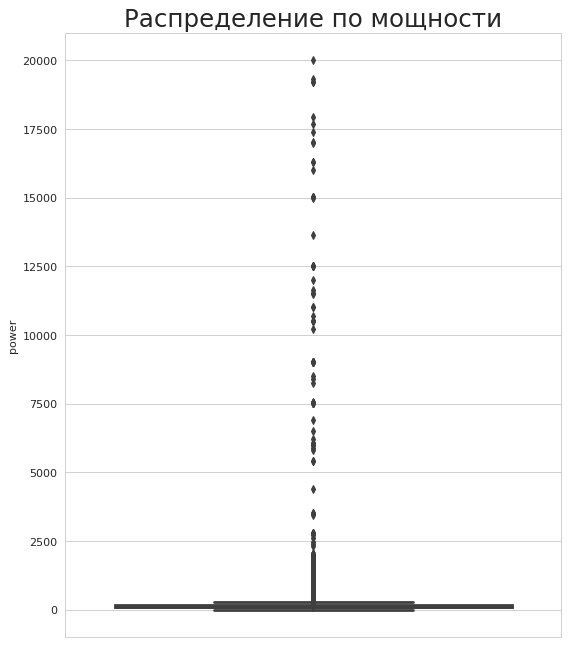

In [28]:
name = 'Распределение по мощности'

plt.figure(figsize=(8,10), dpi= 80)
sns.set_style('whitegrid')
sns.boxplot(y='power', data=data_new, orient='h', linewidth=2.5)
plt.title(name, fontsize=22)
   
plt.show()

Мы наблюдаем основную часть данных от 0 до примерно 1500. (хотя это довольно мощные машины, конкретно я не уверена, что тут такие данные)

In [29]:
# В списке брендов автомобилей, предложенных нам, нет автомобилей выше 700 л.с. и меньше 70 л.с., 
# поэтому мы возьмем значения в этом диапозоне. 

data_new = data_new.query('70 <= power <= 700')

Text(0.5, 1.0, 'Распределенние данных по мощности')

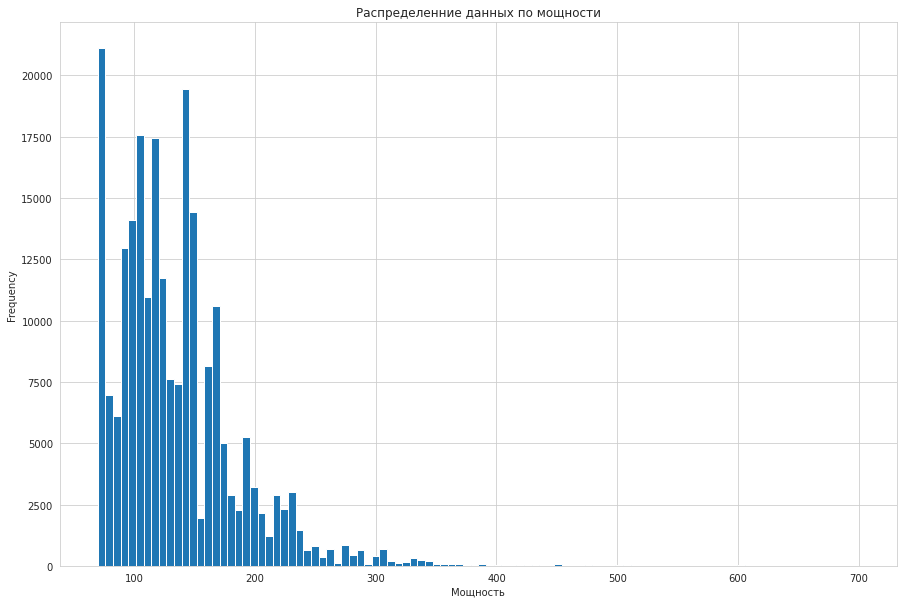

In [30]:
data_new['power'].plot(kind='hist', bins=100, x='power', grid=True, figsize=(15, 10))
plt.xlabel('Мощность')
plt.title('Распределенние данных по мощности')

In [31]:
data_new['power'].isna().sum()

0

In [32]:
data_new['model'].isna().sum()

0

In [33]:
data_new['fuel_type'].value_counts()

petrol      130592
gasoline     82039
lpg           4078
cng            405
hybrid         175
other           39
electric        19
Name: fuel_type, dtype: int64

Предполагаю, что пропуски образовались из-за того, что по умолчанию большинство автомобилей используют бензин, поэтому это не сочли нужным указать. Заменим пропуски на petrol.

In [34]:
data_new['fuel_type'] = data_new['fuel_type'].fillna(value='petrol')

In [35]:
data_new['fuel_type'].isna().sum()

0

In [36]:
data_new['not_repaired'].value_counts()

no     182891
yes     16489
Name: not_repaired, dtype: int64

Данные пропуски заменим на yes, так как, если эта информация не была указана, то машина не чинилась.

In [37]:
data_new['not_repaired'] = data_new['not_repaired'].fillna(value='yes')

In [38]:
data_new['not_repaired'].isna().sum()

0

In [39]:
def change_type(data_new, categorial_columns):
    data_new[categorial_columns] = data_new[categorial_columns].astype('category')
    return data_new

categorial_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
numeric_columns = ['registration_year' 'power', 'kilometer']

In [40]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227824 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              227824 non-null  int64 
 1   vehicle_type       227824 non-null  object
 2   registration_year  227824 non-null  int64 
 3   gearbox            227824 non-null  object
 4   power              227824 non-null  int64 
 5   model              227824 non-null  object
 6   kilometer          227824 non-null  int64 
 7   fuel_type          227824 non-null  object
 8   brand              227824 non-null  object
 9   not_repaired       227824 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.1+ MB


In [41]:
data_new.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

#### Краткий итог

- В исходных данных было 354.369 значений, в ходе удаления/заполнения пропусков мы получили 227.824 данных. Процент потерь составляет 35%
- Были удалены следующие признаки: '***datecrawled***', '***registrationmonth***', '***datecreated***', '***numberofpictures***', '***postalcode***', '***lastseen***', так как они не несли важной информации для дальнейшого обучения моделей.
- Названия колонок было отредактировано и приведено в правильный вид.
- Большинство пропусков было заполнено по тем значениям, которые были доступны.

### Подготовка данных для обучения моделей

#### Кодирование признаков

Скопируем наши данные для Линейной регресси, так как модели CatBoost и LightGBM могут работать с категоральными признаками

In [42]:
data_for_lr = data_new.copy()
data_for_lr.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,yes
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,yes


Произведем прямое кодирование признаков для модели Линейной регресии.

In [43]:
data_ohe_lr = pd.get_dummies(data_for_lr, drop_first=True)
data_ohe_lr.head(5)

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14500,2014,125,30000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,999,1998,101,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [44]:
# разделим данные на обучающую и тестовую выборки

target_ohe_lr = data_ohe_lr['price']
features_ohe_lr = data_ohe_lr.drop('price', axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
        features_ohe_lr, target_ohe_lr, test_size=0.25, random_state=12345)

print('Обучающая выборка: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Тестовая выборка: ', features_test_ohe.shape,  target_test_ohe.shape)

Обучающая выборка:  (170868, 300) (170868,)
Тестовая выборка:  (56956, 300) (56956,)


#### Разделение признаков на выборки

In [45]:
# переведем признаки в категоральные

data_new[['vehicle_type','gearbox', 'model', 'fuel_type','brand', 'not_repaired']] = data_new[['vehicle_type','gearbox', 'model', 'fuel_type','brand', 'not_repaired']].astype('category')
# data_new['not_repaired'] = data_new['not_repaired'].astype('int64')

In [46]:
#подготовим признаки для моделей CatBoost и LightGBM

target = data_new['price']
features = data_new.drop('price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=12345)

print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (170868, 9) (170868,)
Тестовая выборка:  (56956, 9) (56956,)


#### Краткий итог

- Было произведено прямое кодирование признаков для обучения модели линейной регресси.
- Категоральные признаки были разделены на обучающую и тестовую выборки в соотношении 75:25.
- Признаки для CatBoost и LightGBM были разделены на выборки в соотношении 75:25, использовалась изначальная база данных.

## Обучение моделей

Мы рассмотрим три модели - Линейная регрессия, CatBoost и LightGBM.

In [47]:
# для наглядности результатов сведем после обучения полученные метрики в таблицу

def metrics(rmse, fit_time, pred_time, model, data):
    data.loc[model, 'RMSE'] = rmse
    data.loc[model, 'time_fit'] = fit_time
    data.loc[model, 'time_pred'] = pred_time
    return data

In [48]:
# таблица для сравнения результатов обучения моделей

compare_models = pd.DataFrame(columns=['RMSE', 'time_fit', 'time_pred'])

#### Создание константной модели

Константная модель нам необходима для предсказания среднего значения целевого признака. Далее будем сравнивать наши модели с константной.

In [49]:
%%time

dummy = DummyRegressor()
dummy_model = dummy.fit(features_train, target_train)

dummy_pred_test = dummy_model.predict(features_test)

rmse_dummy = mean_squared_error(target_test, dummy_pred_test)**0.5

print('RMSE для константной модели на тестовой выборке: {:.2f}'.format(rmse_dummy))

RMSE для константной модели на тестовой выборке: 4689.09
CPU times: user 5.15 ms, sys: 0 ns, total: 5.15 ms
Wall time: 9.3 ms


Результат константной модели показывает, что она в среднем ошибается на 4,7 тыс.евро. 

#### Линейная регрессия

In [50]:
%%time

# подберем наилучшие параметры с помощью кросс-валидации

model_lr = LinearRegression()
params_lr = {'normalize':[True,False], 'copy_X':[True, False]}

random_cv = RandomizedSearchCV(model_lr, params_lr, cv=5)
random_cv.fit(features_train_ohe, target_train_ohe)

print('Лучшие гиперпараметры для модели:', random_cv.best_params_) 

Лучшие гиперпараметры для модели: {'normalize': False, 'copy_X': True}
CPU times: user 2min 39s, sys: 12.8 s, total: 2min 52s
Wall time: 1min 46s


In [51]:
# обучим модель с подобранными параметрами

start = time.time()
model_lr_best = LinearRegression(normalize=False, copy_X=True)
model_lr_best.fit(features_train_ohe, target_train_ohe)
end = time.time()
fit_time_lr = end - start

In [52]:
start = time.time()
model_lr_best_pred = model_lr_best.predict(features_test_ohe)
end = time.time()
pred_time_lr = end - start
rmse_lr = mean_squared_error(target_test_ohe, model_lr_best_pred)**0.5

print('RMSE для Линейной регресии на тестовой выборке: {:.2f}'.format(rmse_lr))

RMSE для Линейной регресии на тестовой выборке: 2678.97


In [53]:
metrics('{:.2f}'.format(rmse_lr), '{:.2f}'.format(fit_time_lr), '{:.2f}'.format(pred_time_lr), 'LinearRegression', compare_models)

,RMSE,time_fit,time_pred
LinearRegression,2678.97,5.18,0.11


#### CatBoost

In [54]:
cb_features = ['vehicle_type','gearbox', 'model', 'fuel_type','brand','not_repaired']

In [55]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

model_cb = CatBoostRegressor(iterations=100, verbose=False, cat_features = cb_features)
params_cb = {'learning_rate':[0.1, 0.3, 0.5], 'depth':[5,10, 15]}

grid_cb = GridSearchCV(model_cb, params_cb, scoring='neg_mean_squared_error',  cv=3, n_jobs = -1)
grid_cb.fit(features_train, target_train)

rmse=(-grid_cb.best_score_)**0.5

print('RMSE модели CatBoost на обучающей выборке: {:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', grid_cb.best_params_)

RMSE модели CatBoost на обучающей выборке: 1689.83
Лучшие гиперпараметры для модели:  {'depth': 15, 'learning_rate': 0.3}
CPU times: user 1min 24s, sys: 14.2 s, total: 1min 38s
Wall time: 10min 5s


In [56]:
#обучим модель с подобранными параметрами

start = time.time()
model_cb_best = CatBoostRegressor(iterations=100, verbose=False, cat_features = cb_features, 
                        learning_rate=0.3, depth=15, random_state=45)
model_cb_best.fit(features_train, target_train)
end = time.time()
fit_time_cb = end - start

In [57]:
start = time.time()
model_cb_best_pred = model_cb_best.predict(features_test)
end = time.time()
pred_time_cb = end - start
rmse_cb = mean_squared_error(target_test, model_cb_best_pred)**0.5
print('RMSE для CatBoost на тестовой выборке: {:.2f}'.format(rmse_cb))

RMSE для CatBoost на тестовой выборке: 1649.35


In [58]:
metrics('{:.2f}'.format(rmse_cb), '{:.2f}'.format(fit_time_cb), '{:.2f}'.format(pred_time_cb), 'CatBoostRegressor', compare_models)

,RMSE,time_fit,time_pred
LinearRegression,2678.97,5.18,0.11
CatBoostRegressor,1649.35,53.99,0.09


####  LightGBM

In [59]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

model_lgmr = LGBMRegressor(random_state=45)
params_lgmr = {'max_depth': [2, 4, 6], 'learning_rate': [0.03, 0.1], 'n_estimators': [50, 100, 200, 500, 1000]}

grid_lgmr = GridSearchCV(model_lgmr, params_lgmr, scoring='neg_mean_squared_error', cv=3)
grid_lgmr.fit(features_train, target_train, verbose=True)

rmse=(-grid_lgmr.best_score_)**0.5

print('RMSE модели LightGBM на обучающей выборке: {:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', grid_lgmr.best_params_)

RMSE модели LightGBM на обучающей выборке: 1662.67
Лучшие гиперпараметры для модели:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
CPU times: user 9min 33s, sys: 4.81 s, total: 9min 38s
Wall time: 4min 59s


In [60]:
#обучим модель с подобранными параметрами

start = time.time()
model_lgmr_best = LGBMRegressor(max_depth = 6, learning_rate = 0.1, n_estimators = 1000, random_state=45)
model_lgmr_best.fit(features_train, target_train, verbose = True)
end = time.time()
fit_time_lgmr = end - start

In [61]:
start = time.time()
model_lgmr_best_pred = model_lgmr_best.predict(features_test)
end = time.time()
pred_time_lgmr = end - start
rmse_lgmr = mean_squared_error(target_test, model_lgmr_best_pred)**0.5
print('RMSE для LightGBM на тестовой выборке: {:.2f}'.format(rmse_lgmr))

RMSE для LightGBM на тестовой выборке: 1627.58


In [62]:
final_analytic = metrics('{:.2f}'.format(rmse_lgmr), '{:.2f}'.format(fit_time_lgmr), '{:.2f}'.format(pred_time_lgmr), 'LGBMRegressor', compare_models).sort_values(by='RMSE', ascending=True)

#### Краткий итог

- Была создана константная модель, с которой в последствии можно сравнить наши основные модели.
- Для каждой модели был подобран свой тип признаков. 
- Были обучены 3 модели - Линейная реграссия, CatBoost, LightGBM.

## Анализ моделей

In [63]:
display(final_analytic)

,RMSE,time_fit,time_pred
LGBMRegressor,1627.58,9.07,4.74
CatBoostRegressor,1649.35,53.99,0.09
LinearRegression,2678.97,5.18,0.11


#### Краткий итог

- Самая быстрообучаемая модель - это Линейная регрессия.
- Наилучший показатель RMSE показала LGBMRegressor модель.
- Наилучшее время предсказаний показала модель CatBoostRegressor.
- Не смотря на то, что Линейная регрессия показала хорошие результаты при обучении и предсказании, метрика RMSE у нее значительно хуже, чем у остальных.
- Самое долгое время обучения получилось у CatBoost.

Не смотря на то, что время предсказания у LGBM самое высокое, я все равно посоветовала бы именно эту модель заказчику. К сожалению, ни одна модель не превосходит остальные по всем параметрам, у отдельной модели отдельные параметры лучше остальных.